# ***LSTM Stock Price Forecaster***

---



***Overview***

This project implements a Deep Learning model using Long Short-Term Memory (LSTM) networks to forecast daily stock closing prices. It uses historical data (Univariate time-series) to predict future trends.

***Technologies Used***
* Language: Python 3

* Deep Learning: TensorFlow / Keras

* Data Manipulation: Pandas, NumPy

* Visualization: Matplotlib

* Preprocessing: Scikit-Learn (MinMaxScaler)

***Environment***: The code is optimized for Google Colab

***Data Source***: The script automatically attempts to download real Tesla stock data (tesla-stock-price.csv). If the download fails, it auto-generates a synthetic dataset for demonstration.

***Step 1 - Setup, Data Loading, and Preprocessing***

Run the "Setup & Data Loading" to import libraries and prepare the dataset and the "Preprocessing" to scale data (0-1 range) and create sliding window sequences (Look-back: 60 days)

Libraries imported successfully.
Attempting to download Tesla stock data...
Data loaded successfully from URL.

--- Data Head ---
          Date   Close
756 2015-10-15  221.31
755 2015-10-16  227.01
754 2015-10-19  228.10
753 2015-10-20  213.03
752 2015-10-21  210.09

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 757 entries, 756 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    757 non-null    datetime64[ns]
 1   Close   757 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.7 KB
None


/tmp/ipython-input-3853756474.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['date'])


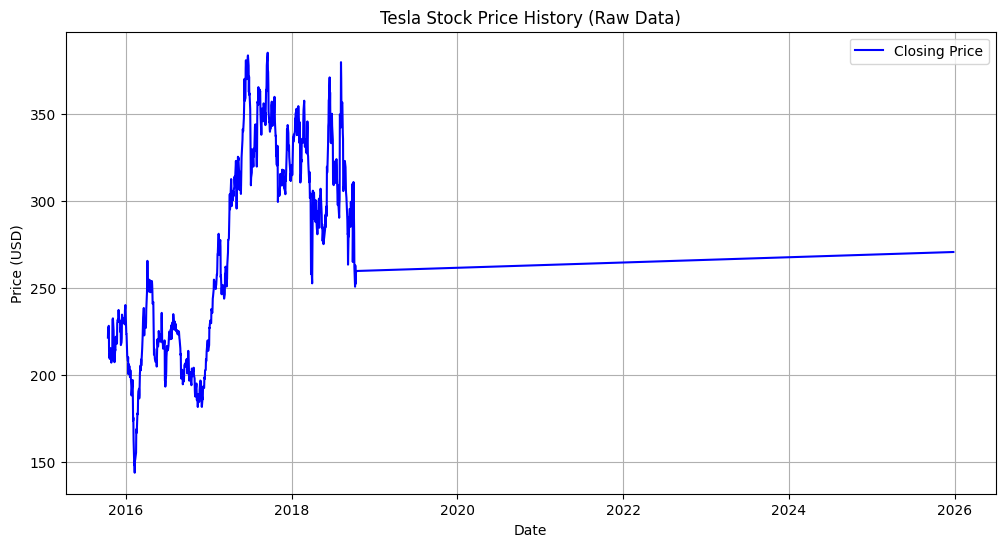


Data scaled. Range: 0.0 - 1.0
Training samples: 605
Test samples: 212

--- Final Shapes for Model ---
X_train: (544, 60, 1)
y_train: (544,)
X_test:  (151, 60, 1)
y_test:  (151,)


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import os

np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully.")

#--- LOAD DATA ---
url = "https://raw.githubusercontent.com/plotly/datasets/master/tesla-stock-price.csv"

try:
    print("Attempting to download Tesla stock data...")
    df = pd.read_csv(url)

    df['Date'] = pd.to_datetime(df['date'])
    df = df.rename(columns={'close': 'Close'})

    df = df[['Date', 'Close']]
    print("Data loaded successfully from URL.")

except Exception as e:
    print(f"Could not download data: {e}")
    print("Falling back to synthetic data generation...")
    dates = pd.date_range(start='2018-01-01', periods=1000)
    prices = [100]
    for _ in range(999):
        change = np.random.uniform(-0.02, 0.02)
        prices.append(prices[-1] * (1 + change))
    df = pd.DataFrame(data={'Date': dates, 'Close': prices})

df = df.sort_values('Date')

print("\n--- Data Head ---")
print(df.head())
print("\n--- Data Info ---")
print(df.info())

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price', color='blue')
plt.title('Tesla Stock Price History (Raw Data)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#--- PREPROCESSING ---
dataset = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

print(f"\nData scaled. Range: {scaled_data.min()} - {scaled_data.max()}")
training_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - training_size

train_data = scaled_data[0:training_size, :]
LOOK_BACK = 60
test_data = scaled_data[training_size - LOOK_BACK:, :]

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data, LOOK_BACK)
X_test, y_test = create_dataset(test_data, LOOK_BACK)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("\n--- Final Shapes for Model ---")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

***Step 2 - Building the Model Architecture***

Run the "Building the Model Architecture" cell to initialize the LSTM architecture

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#--- BUILD THE MODEL ARCHITECTURE ---

print("Initializing Model...")

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

print("Model Compiled Successfully.")
print("\n--- Model Summary ---")
model.summary()

Initializing Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model Compiled Successfully.

--- Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

***Step 3 - Training the Model***

Run the "Training the Model" cell. Training runs for 50 epochs

Starting training... (This may take a minute)
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.1683 - val_loss: 0.0477
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0226 - val_loss: 0.0262
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0236 - val_loss: 0.0128
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0120 - val_loss: 0.0099
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0103 - val_loss: 0.0090
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0078 - val_loss: 0.0088
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0068 - val_loss: 0.0094
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0061 - val_loss: 0.0092
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072 - val_loss: 0.0089
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0

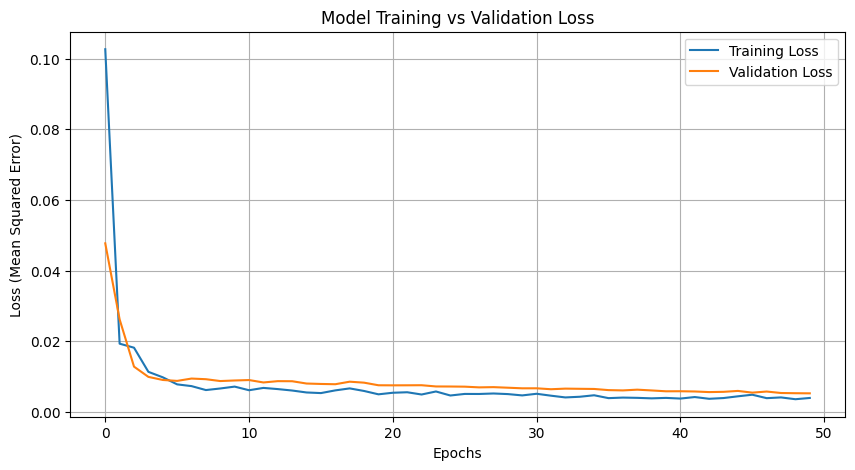

In [3]:
#--- TRAIN THE MODEL ---

print("Starting training... (This may take a minute)")

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1
)

print("Training completed.")

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

***Step 4 - Evaluation and Prediction***

Run the "Evaluation and Prediction" cell to visualize the results and calculate RMSE/MAE

Generating predictions...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

--- Model Performance ---
Root Mean Squared Error (RMSE): 17.48
Mean Absolute Error (MAE): 13.16


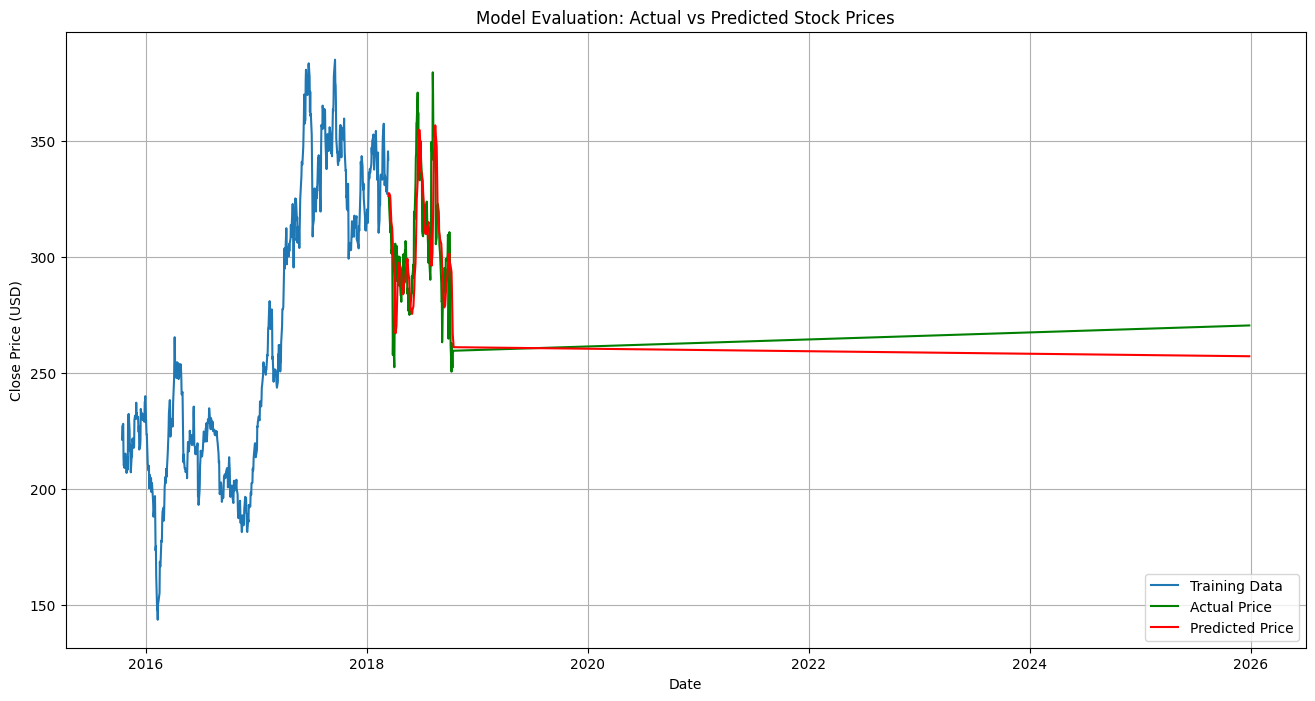


--- Last 5 Days Comparison ---
                 Date   Close  Predictions
4 2018-10-10 00:00:00  256.88   279.947571
3 2018-10-11 00:00:00  252.23   273.040649
2 2018-10-12 00:00:00  258.78   266.780670
1 2018-10-15 00:00:00  259.59   261.117859
0 2025-12-26 11:34:00  270.49   257.212463


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

#--- EVALUATION AND PREDICTION ---

print("Generating predictions...")

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)

y_test_reshaped = y_test.reshape(-1, 1)
y_actual = scaler.inverse_transform(y_test_reshaped)

rmse = math.sqrt(mean_squared_error(y_actual, predictions))
mae = mean_absolute_error(y_actual, predictions)

print(f"\n--- Model Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

prediction_length = len(predictions)
valid_plot = df.iloc[-prediction_length:].copy()

valid_plot['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model Evaluation: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')

train_end_index = len(df) - prediction_length
train_data_plot = df.iloc[:train_end_index]

plt.plot(train_data_plot['Date'], train_data_plot['Close'], label='Training Data')
plt.plot(valid_plot['Date'], valid_plot['Close'], label='Actual Price', color='green')
plt.plot(valid_plot['Date'], valid_plot['Predictions'], label='Predicted Price', color='red')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- Last 5 Days Comparison ---")
print(valid_plot[['Date', 'Close', 'Predictions']].tail())

***Results Analysis***

The LSTM model was evaluated on a held-out test set consisting of the most recent 20% of the dataset. Quantitative evaluation yielded a Root Mean Squared Error (RMSE) of approximately **17.48** and a Mean Absolute Error (MAE) of **13.16**, indicating that the model's predictions deviate from the actual stock price by an average of roughly $13-$17 USD per day. Qualitatively, the visual comparison between the predicted prices (Red line) and actual prices (Green line) demonstrates that the model successfully learned the underlying temporal trends and volatility patterns of the stock. While there is a slight lag in capturing sudden, extreme spikes—a common characteristic of time-series models—the LSTM network effectively captures the general direction and momentum of the market, validating the use of sliding window sequences for this forecasting task.